##Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# specify the desired data location to the current working directory
%cd /content/drive/MyDrive/Dataset

/content/drive/.shortcut-targets-by-id/1hQJhZXCBbc369GWFH06FCrflHQ8EO2xS/Dataset


In [ ]:
# Keras prepocessing library
! pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00


##Import Library

In [ ]:
# Get the required Library
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import ResNet50V2, VGG16, MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, MaxPool2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras.models import Model, Sequential
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory, ImageDataGenerator
from collections import defaultdict


##Data Exploration

In [ ]:
os.listdir('/content/drive/MyDrive/Dataset/DatasetV2/Dataset/Split_300/Training')

['Academic_Art',
 'Art_Nouveau',
 'Baroque',
 'Expressionism',
 'Japanese_Art',
 'Neoclassicism',
 'Primitivism',
 'Realism',
 'Renaissance',
 'Rococo',
 'Romanticism',
 'Symbolism',
 'Abstract']

In [ ]:
os.listdir('/content/drive/MyDrive/Dataset/DatasetV2/Dataset/Split_300/Validation')

['Academic_Art',
 'Art_Nouveau',
 'Baroque',
 'Expressionism',
 'Japanese_Art',
 'Neoclassicism',
 'Primitivism',
 'Realism',
 'Renaissance',
 'Rococo',
 'Romanticism',
 'Symbolism',
 'Abstract']

In [23]:
train_dir = '/content/drive/MyDrive/Dataset/DatasetV2/Dataset/Split_300/Training'
validation_dir = '/content/drive/MyDrive/Dataset/DatasetV2/Dataset/Split_300/Validation'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

train_dataset = image_dataset_from_directory(train_dir,
                                             label_mode = 'categorical',
                                             image_size = IMG_SIZE,
                                             batch_size = BATCH_SIZE,
                                             shuffle = True)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  label_mode ='categorical',
                                                  image_size = IMG_SIZE,
                                                  batch_size = BATCH_SIZE,
                                                  shuffle = True)


Found 3120 files belonging to 13 classes.
Found 780 files belonging to 13 classes.


In [ ]:
# Fungsi untuk histogram equalization
def histogram_equalization(image):
    image = np.array(image)
    if len(image.shape) == 3 and image.shape[2] == 3:  # RGB image
        img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    elif len(image.shape) == 2:  # Grayscale image
        image = cv2.equalizeHist(image)
    return image

#def histogram_equalization_wrapper(image):
    image = tf.numpy_function(histogram_equalization, [image], tf.uint8)
    return image

Found 3120 files belonging to 13 classes.
['Abstract', 'Academic_Art', 'Art_Nouveau', 'Baroque', 'Expressionism', 'Japanese_Art', 'Neoclassicism', 'Primitivism', 'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism']


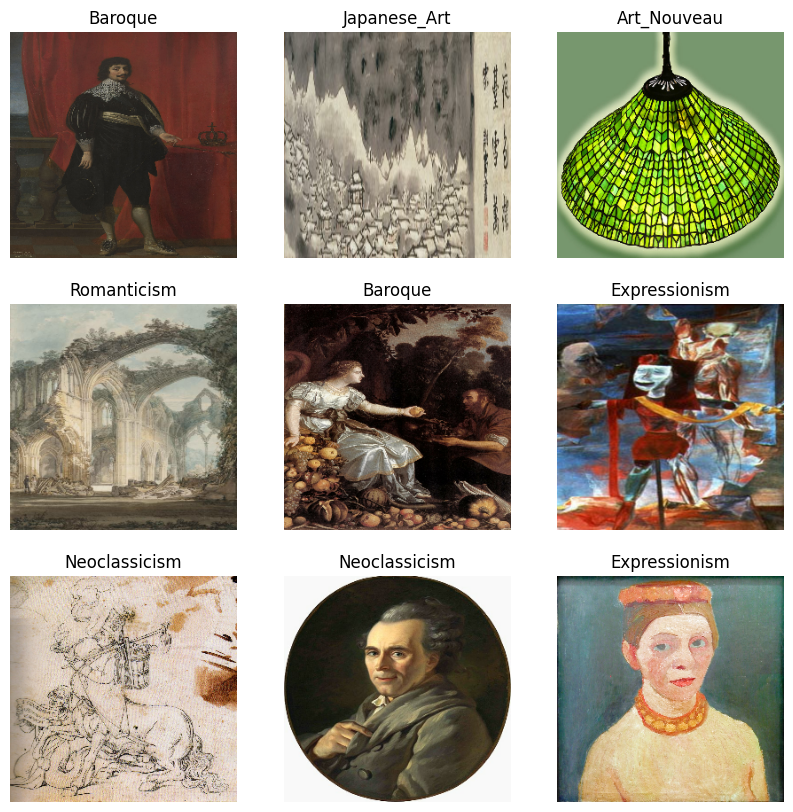

In [ ]:
data = image_dataset_from_directory(train_dir)

class_names = data.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

##Data Preprocessing

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

##Architecture

###Load MobileNetV2 Pretrained Model

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
feature, target = next(iter(train_dataset))
feature_batch = base_model(feature)
print(feature_batch.shape)

(32, 7, 7, 1280)


###Freeze Layer

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


###Create New Dense Layer

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)

x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.25)(x)

x = layers.Dense(13, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = tf.keras.Model(inputs, x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                             

###Training Preperation

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

###Training

In [ ]:
initial_epochs = 1000

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[es_callback])

Epoch 1/1000
98/98 [==============================] - 781s 8s/step - loss: 2.7968 - accuracy: 0.0913 - val_loss: 2.6163 - val_accuracy: 0.1731
Epoch 2/1000
98/98 [==============================] - 92s 866ms/step - loss: 2.6759 - accuracy: 0.1330 - val_loss: 2.5339 - val_accuracy: 0.2295
Epoch 3/1000
98/98 [==============================] - 89s 840ms/step - loss: 2.5942 - accuracy: 0.1670 - val_loss: 2.4595 - val_accuracy: 0.2731
Epoch 4/1000
98/98 [==============================] - 86s 813ms/step - loss: 2.5301 - accuracy: 0.1872 - val_loss: 2.3865 - val_accuracy: 0.3244
Epoch 5/1000
98/98 [==============================] - 83s 778ms/step - loss: 2.4590 - accuracy: 0.2163 - val_loss: 2.3125 - val_accuracy: 0.3744
Epoch 6/1000
98/98 [==============================] - 86s 811ms/step - loss: 2.3646 - accuracy: 0.2612 - val_loss: 2.2358 - val_accuracy: 0.4090
Epoch 7/1000
98/98 [==============================] - 83s 793ms/step - loss: 2.3138 - accuracy: 0.2760 - val_loss: 2.1623 - val_accu

###Plot Loss And Accuracy

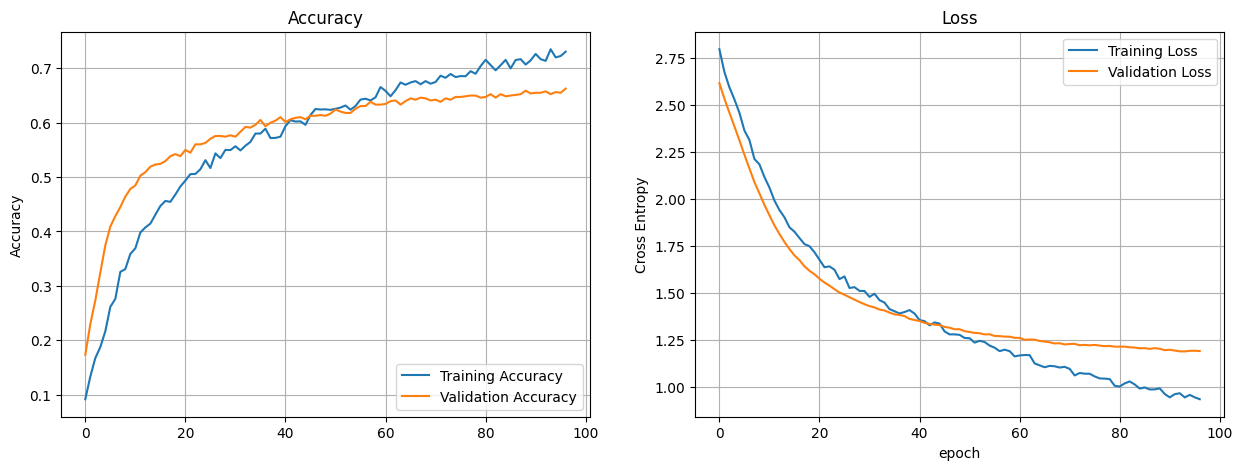

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.grid()
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

###Fine Tuning

In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                             

In [ ]:
fine_tune_epochs = 500
total_epochs =  21 + fine_tune_epochs
print(total_epochs)

521


In [ ]:
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[es_callback])

Epoch 97/521
98/98 [==============================] - 106s 881ms/step - loss: 0.9718 - accuracy: 0.7125 - val_loss: 1.1582 - val_accuracy: 0.6718
Epoch 98/521
98/98 [==============================] - 85s 817ms/step - loss: 0.9020 - accuracy: 0.7343 - val_loss: 1.1418 - val_accuracy: 0.6782
Epoch 99/521
98/98 [==============================] - 88s 839ms/step - loss: 0.8876 - accuracy: 0.7439 - val_loss: 1.1106 - val_accuracy: 0.6679
Epoch 100/521
98/98 [==============================] - 88s 833ms/step - loss: 0.8588 - accuracy: 0.7577 - val_loss: 1.1187 - val_accuracy: 0.6731
Epoch 101/521
98/98 [==============================] - 87s 824ms/step - loss: 0.8422 - accuracy: 0.7542 - val_loss: 1.0868 - val_accuracy: 0.6872
Epoch 102/521
98/98 [==============================] - 88s 844ms/step - loss: 0.7776 - accuracy: 0.7750 - val_loss: 1.0650 - val_accuracy: 0.6885
Epoch 103/521
98/98 [==============================] - 89s 838ms/step - loss: 0.7639 - accuracy: 0.7840 - val_loss: 1.0895 - v

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

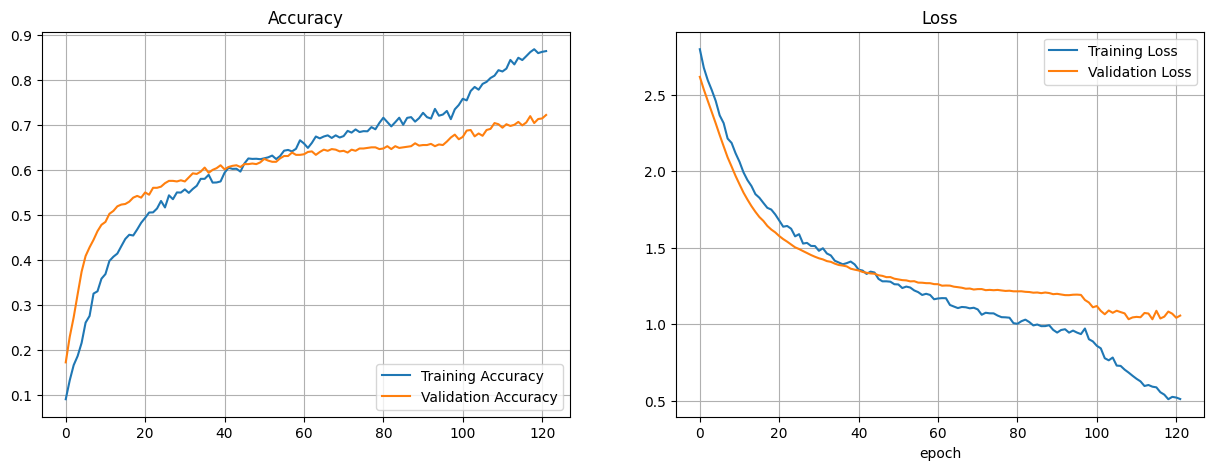

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.grid()
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Menggunakan callback EarlyStopping dan ReduceLROnPlateau
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

In [ ]:
# Melatih model dengan dataset yang sudah di-augmentasi
history_fine = model.fit(train_dataset,
                         epochs=500,  # Total epoch yang ingin dilanjutkan
                         initial_epoch=121,  # Memulai dari epoch ke-20
                         validation_data=validation_dataset,
                         callbacks=[es_callback, reduce_lr])

Epoch 122/500
98/98 [==============================] - 101s 835ms/step - loss: 0.4589 - accuracy: 0.8878 - val_loss: 1.0371 - val_accuracy: 0.7192 - lr: 1.0000e-06
Epoch 123/500
98/98 [==============================] - 88s 829ms/step - loss: 0.4528 - accuracy: 0.8885 - val_loss: 1.0362 - val_accuracy: 0.7218 - lr: 1.0000e-06
Epoch 124/500
98/98 [==============================] - 86s 810ms/step - loss: 0.4446 - accuracy: 0.8901 - val_loss: 1.0402 - val_accuracy: 0.7269 - lr: 1.0000e-06
Epoch 125/500
98/98 [==============================] - 88s 825ms/step - loss: 0.4423 - accuracy: 0.8926 - val_loss: 1.0342 - val_accuracy: 0.7269 - lr: 1.0000e-06
Epoch 126/500
98/98 [==============================] - 86s 808ms/step - loss: 0.4265 - accuracy: 0.9022 - val_loss: 1.0309 - val_accuracy: 0.7282 - lr: 1.0000e-06
Epoch 127/500
98/98 [==============================] - 89s 838ms/step - loss: 0.4344 - accuracy: 0.8936 - val_loss: 1.0454 - val_accuracy: 0.7218 - lr: 1.0000e-06
Epoch 128/500
98/98 [

In [ ]:
# Save the model
model.save('model8_ArtNaon.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
tf.keras.models.save_model(model, '/content/')

In [ ]:
# You can also use this cell as a shortcut for downloading your model
from google.colab import files
files.download("model8_ArtNaon.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Convert To Tensorflow Lite

In [ ]:
# tflite_model = tf.keras.models.load_model('/content/drive/MyDrive/model.h5') #save model .h5
# converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)
# tflite_save = converter.convert()
# open("/content/drive/MyDrive/CAPSTONE BANGKIT/Save_model.tflite", "wb").write(tflite_save)

In [12]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Load the Model
import tensorflow as tf
from tensorflow.keras.models import load_model

# Path to the model file in Google Drive
model_path = '/content/drive/MyDrive/Dataset/Model/model8_ArtNaon.h5'

# Load the model
model = load_model(model_path)

# Step 3: Prepare Test/Validation Data
# Example data loading (replace with actual data loading and preprocessing)
import numpy as np

validation_dir = '/content/drive/MyDrive/Dataset/DatasetV2/Dataset/Split_300/Validation'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

y_test = image_dataset_from_directory(validation_dir,
                                                  label_mode ='categorical',
                                                  image_size = IMG_SIZE,
                                                  batch_size = BATCH_SIZE,
                                                  shuffle = True)

# Step 4: Evaluate the Model
loss, accuracy = model.evaluate(y_test, verbose=2)

# Print the results
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 780 files belonging to 13 classes.
25/25 - 20s - loss: 1.0309 - accuracy: 0.7282 - 20s/epoch - 787ms/step
Test Loss: 1.0309196710586548
Test Accuracy: 0.728205144405365


In [18]:
# Training Data Path and Image gen (Normalization)
TRAINING_DIR = "/content/drive/MyDrive/Dataset/DatasetV2/Dataset/Training"
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation Data Path and Image gen (Normalization)
VALIDATION_DIR = "/content/drive/MyDrive/Dataset/DatasetV2/Dataset/Validation"
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 7280 images belonging to 13 classes.
Found 1820 images belonging to 13 classes.


In [14]:
batch_size = 32

1/1 [==============================] - 1s 791ms/step


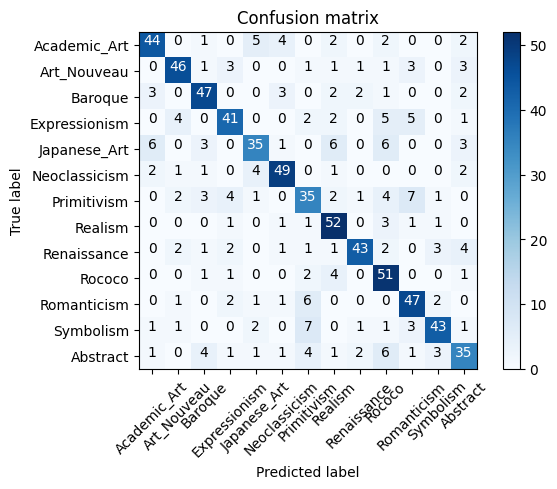

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import itertools

# Load your trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset/Model/model8_ArtNaon.h5')

# Menghitung jumlah sampel dalam dataset validasi
validation_samples = 0
for images, labels in validation_dataset:
    validation_samples += len(labels)

# Fungsi untuk mendapatkan prediksi dari model
def get_predictions_and_labels(dataset, model):
    predictions = []
    labels = []
    for images, batch_labels in dataset:
        batch_predictions = model.predict(images)
        predictions.extend(np.argmax(batch_predictions, axis=1))
        labels.extend(np.argmax(batch_labels, axis=1))
    return np.array(predictions), np.array(labels)

# Dapatkan prediksi dan label dari validation_dataset
Y_pred_classes, Y_true = get_predictions_and_labels(validation_dataset, model)

# Hitung confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Nama kelas (sesuaikan dengan kelas Anda)
class_names = ['Academic_Art', 'Art_Nouveau', 'Baroque', 'Expressionism', 'Japanese_Art', 'Neoclassicism',
               'Primitivism', 'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism', 'Abstract']

# Fungsi untuk plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Fungsi ini mencetak dan menampilkan confusion matrix.
    Normalisasi bisa diterapkan dengan mengatur normalize=True.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot confusion matrix dengan nama kelas
plot_confusion_matrix(confusion_mtx, classes=class_names)

# Menampilkan plot
plt.show()